In [57]:
#!/usr/bin/env python3

import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from pathlib import Path

# this makes all plots look nicer, and high dpi
# sn.set_theme(style="whitegrid", font_scale=1.0, rc={"figure.dpi": 200})
# set a nicer font
# plt.rcParams["font.family"] = "serif"
# To set some sane defaults
matplotlib.style.use("fivethirtyeight")
matplotlib.style.use("seaborn-dark-palette")
matplotlib.rcParams["font.family"] = "monospace"
matplotlib.rcParams["figure.dpi"] = 200
plt.rcParams["savefig.facecolor"] = "white"
# sn.set_context("talk")

KERNEL_NAMES = {
    0: "cuBLAS",
    1: "Naive",
    2: "GMEM Coalescing",
    3: "SMEM Caching",
    4: "1D Blocktiling",
    5: "2D Blocktiling",
    6: "Vectorized Mem Access",
    7: "Avoid Bank Conflicts (Linearize)",
    8: "Avoid Bank Conflicts (Offset)",
    9: "Warptiling",
}

def parse_file(file):
    """
    The data we want to parse has this format:

    Average elapsed time: (0.005661) s, performance: (24277.4) GFLOPS. size: (4096).
    """
    with open(file, "r") as f:
        lines = [line.strip() for line in f.readlines()]

    data = {"size": [], "gflops": []}
    pattern = "Average elapsed time: \((.*?)\) s, performance: \((.*?)\) GFLOPS. size: \((.*?)\)."
    for line in lines:
        # print(line, re.match(pattern, line))
        if r := re.match(pattern, line):
            # data["size"].append(int(r.group(3).split('x')[0]))
            # data["gflops"].append(float(r.group(2)))
            size = int(r.group(3))
            data["size"].append(size)
            time = float(r.group(1))
            # print(size, time)
            data['gflops'].append(calculate_gflops(size, time, r))
    return data

def calculate_gflops(size, time, r):
    return round(size **3 / 1000000000 / float(r.group(1)),2)


def plot(df: pd.DataFrame):
    """
    The dataframe has 3 columns: kernel, size, gflops

    We want to plot the gflops for each kernel, for each size as a single seaborn multi-line plot.
    """
    save_dir = Path.cwd()

    plt.figure(figsize=(18, 10))
    colors = sn.color_palette("husl", len(df["kernel"].unique()))
    sn.lineplot(data=df, x="size", y="gflops", hue="kernel", palette=colors)
    # also plot points, but without legend
    sn.scatterplot(data=df, x="size", y="gflops", hue="kernel", palette=colors, legend=False)

    # set ticks at actual sizes
    plt.xticks(df["size"].unique())
    # rotate xticks, and align them
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    # add small lines at the xticks

    # display the kernel names right next to the corresponding line
    for i, kernel in enumerate(df["kernel"].unique()):
        # right align the text
        plt.text(
            df[df["kernel"] == i]["size"].iloc[-1],
            df[df["kernel"] == i]["gflops"].iloc[-1] + 100,
            f"{i}:{KERNEL_NAMES[i]}",
            color=colors[i],
            horizontalalignment="left",
            weight="medium",
        )

    # turn of the legend
    plt.gca().get_legend().remove()

    plt.title("Performance of different kernels")
    plt.xlabel("Matrix size (square, one side)")
    plt.ylabel("GFLOPs/s")
    plt.tight_layout()

    plt.savefig(save_dir / "sgemm_benchmark_results.png")





Generate dataframe for kenerl number, matrix size and gflops

In [59]:
results_dir = Path("benchmark_results/sgemm")
assert results_dir.is_dir()
data = []
for filename in results_dir.glob("*.txt"):
    # filenames have the format: <kernel_nr>_output.txt
    if not filename.stem.split("_")[0].isdigit() and "_output" not in filename.stem:
        continue
    # print(filename)
    results_dict = parse_file(filename)
    # print(results_dict)
    kernel_nr = int(filename.stem.split("_")[0])
    for size, gflops in zip(results_dict["size"], results_dict["gflops"]):
        data.append({"kernel": kernel_nr, "size": size, "gflops": gflops})
df = pd.DataFrame(data)
df


,kernel,size,gflops
0,0,128,299.59
1,0,256,1398.10
2,0,512,2200.29
3,0,1024,4067.20
4,0,2048,4441.54


plot DF

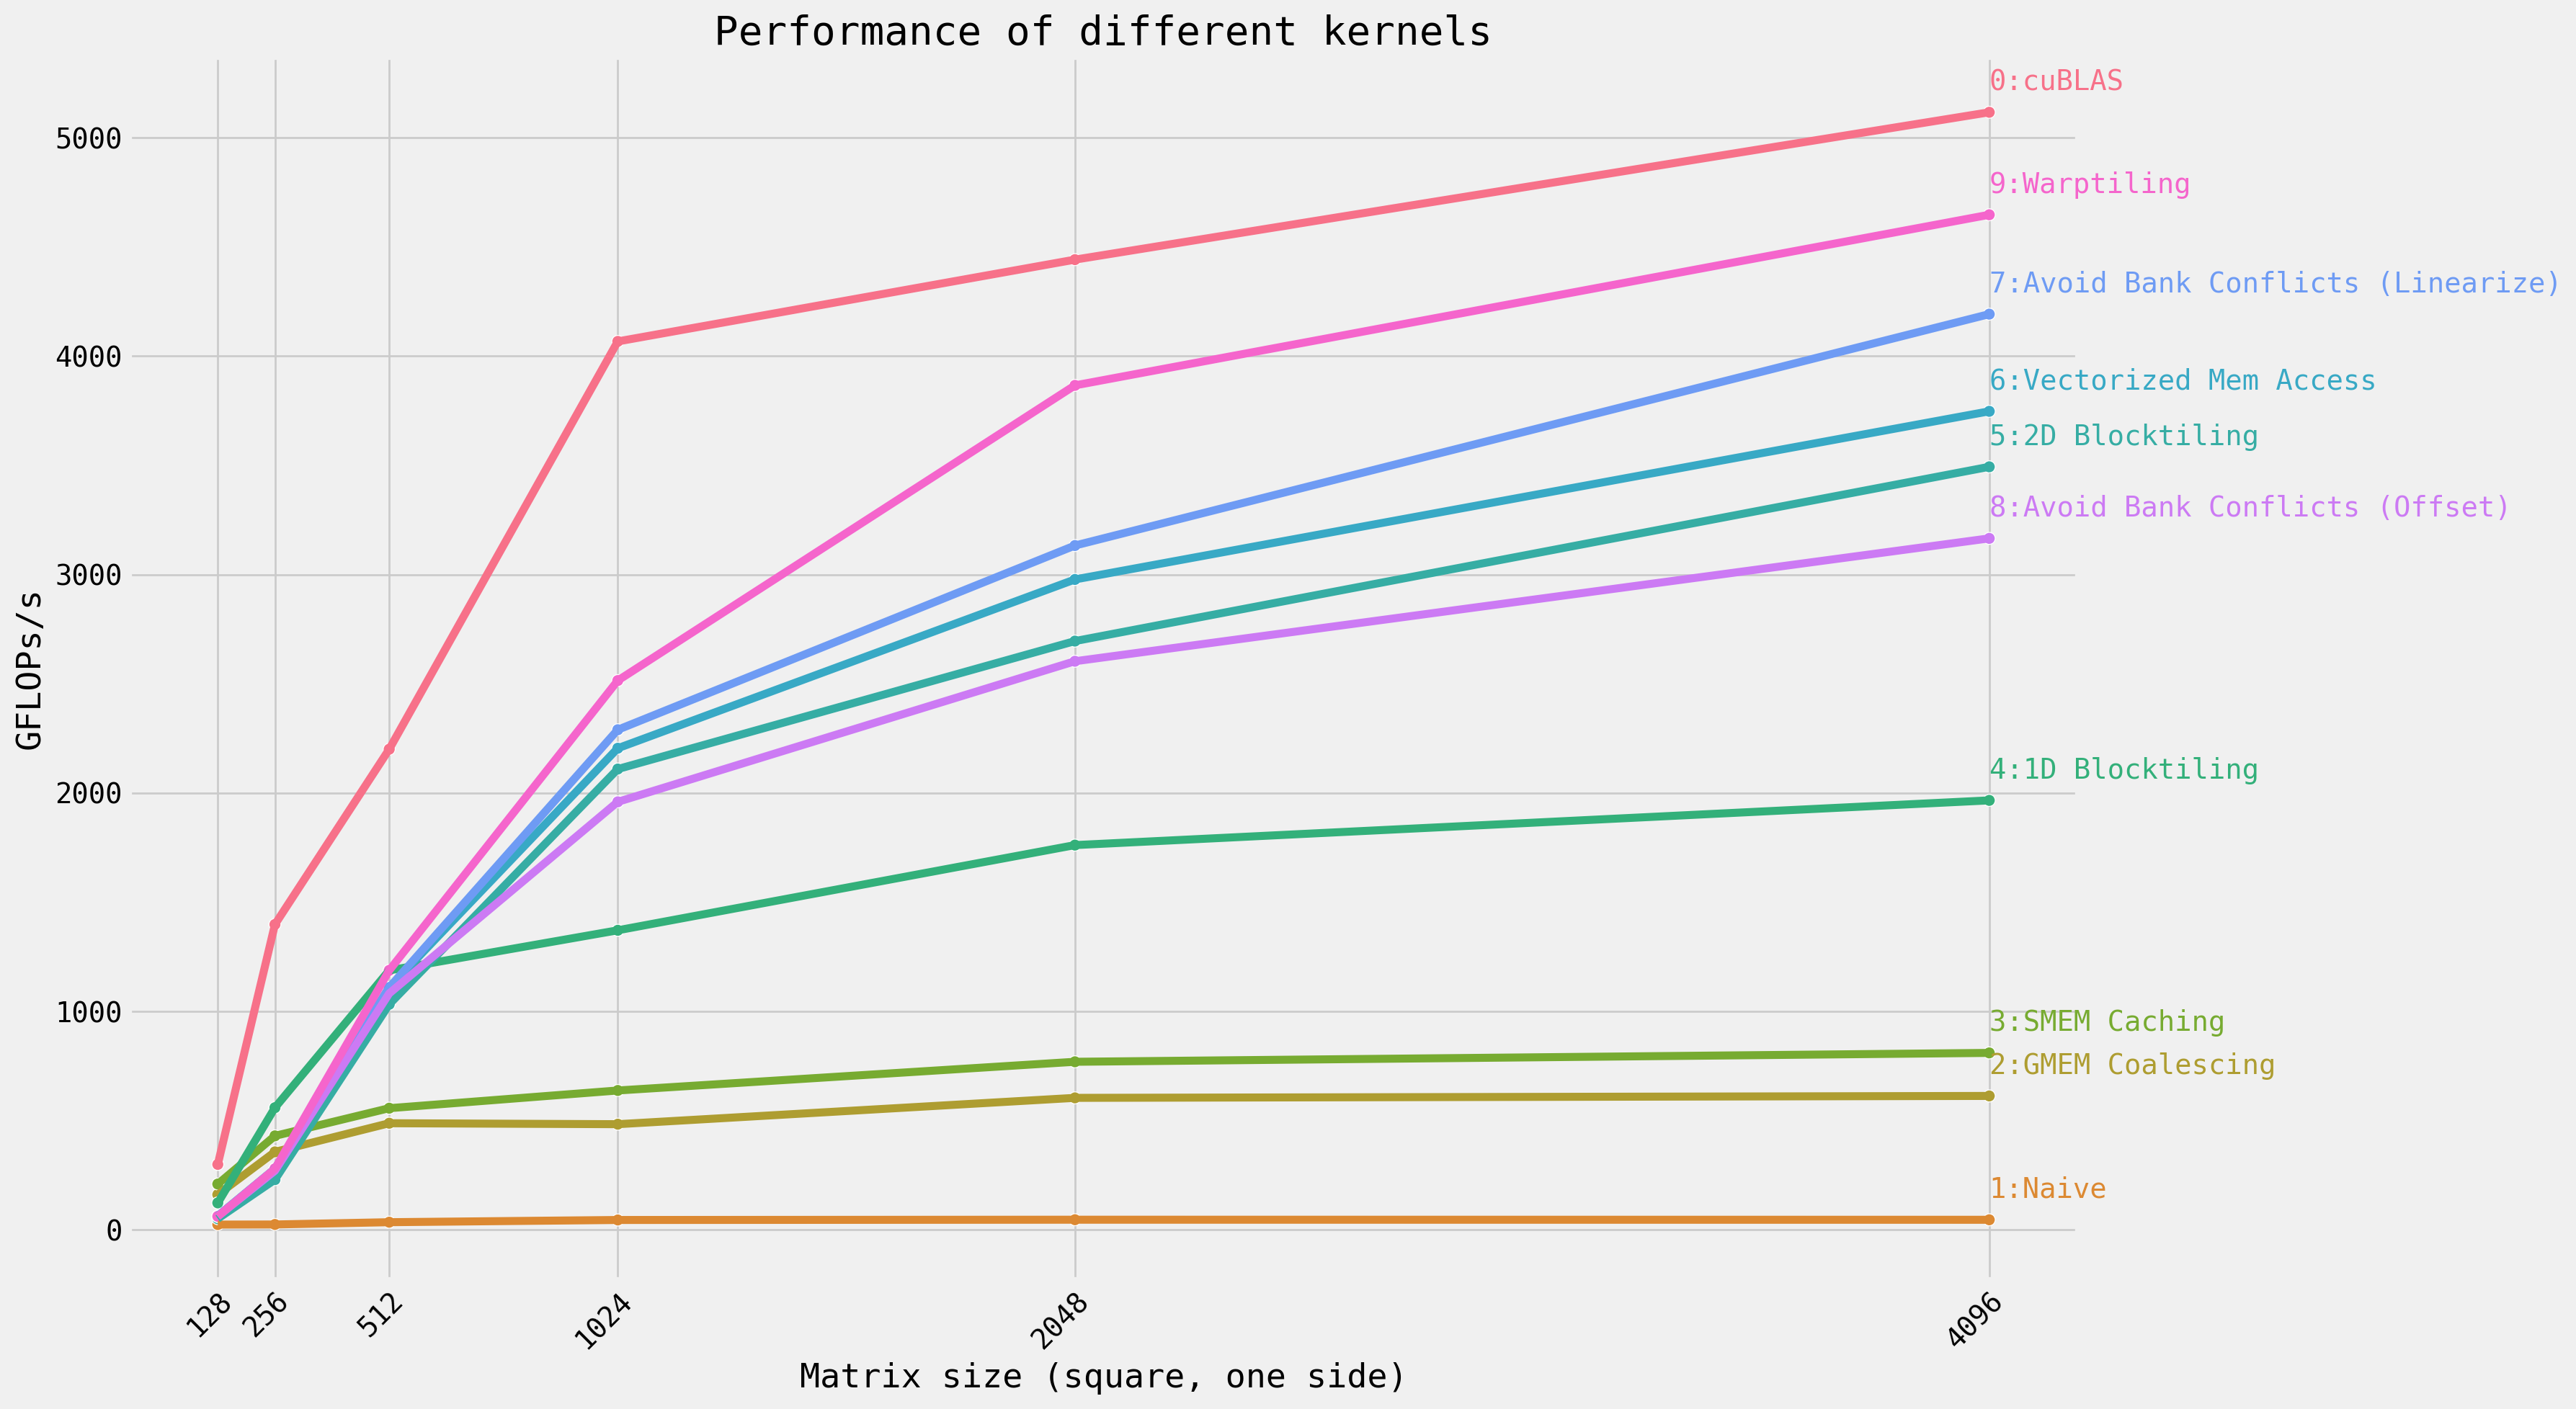

In [60]:
plot(df)

Generate relative performance DF

In [61]:
df_perform = df[df["size"] == 4096].sort_values(by="gflops", ascending=True)[["kernel", "gflops"]]
df_perform["kernel"] = df["kernel"].map({k: f"{k}: {v}" for k, v in KERNEL_NAMES.items()})
df_perform["relperf"] = df["gflops"] / df[df["kernel"] == "0: cuBLAS"]["gflops"].iloc[0]
df_perform["relperf"] = df["relperf"].apply(lambda x: f"{x*100:.1f}%")
df_perform.columns = ["Kernel", "GFLOPs/s", "Performance relative to cuBLAS"]
df_perform


Update README

In [65]:
# # update the README.md with the new results
with open("README.md", "r") as f:
    readme = f.read()
# delete old results
readme = re.sub(
    r"<!-- sgemm_benchmark_results -->.*<!-- sgemm_benchmark_results -->",
    "<!-- sgemm_benchmark_results -->\n{}\n<!-- sgemm_benchmark_results -->".format(
        df_perform.to_markdown(index=False)
    ),
    readme,
    flags=re.DOTALL,
)
# input new results
with open("README.md", "w") as f:
    f.write(readme)
